# 前言

**比乔斯基选股模型**是斯坦福大学商学院教授约瑟夫·比乔斯基的基于市净率、以 历史财务数据为衡量标准的价值选股模型。该选股模型在低市净率选股的 基础上，通过代表盈利水平、财务杠杆及流动性和运营效率的9个财务指标对股票进行优劣筛选。

底层逻辑:比乔斯基认为购买低市净率的上市公司股票即股价和每 股净资产比值相对低的股票是具有安全边际的。但美股中低市净率股票的上市公司更容易陷入财务困境直至破产和退市，于是考虑通过上市公司财务报表分析方法来避免低市净率的投资陷阱。其经典论文《Value Investing: The Use of Historical Financial Statement Information to Separate Winners from Losers》就提出并验证了 FScore 财务分析方法在美国股票市场可以显著提高低市净率股票组合收益率。

## 低市净率比乔斯基选股量化标准

比乔斯基低市净率FScore的9指标模型股票池为市净率为正值且位于全市场的前20%(PB因子升序排序分五组的第一组)；比乔斯基9指标模型选股标准如下： 

**盈利水平**

代表了盈利水平的指标为资产收益率(ROA)、经营现金流量(CFO)、资产收益率变化($\Delta ROA$)、与自然增长性(ACCRUAL)。一家企业的收益率与现金流指标展现了一家企业累积资本的能力。比乔斯基也提到低市净率的上市公司有历史收益不佳的问题，如果在最新财报期能够看到盈利能力并呈现现金净流入，即收益增长趋势，则可以说明这家公司开始 具备改善未来盈利水平的能力。此外，自然增长性表现了收益与现金流的关系。如果现金的流入能够超越收益，则说明了企业在未来的增长有更好的基础。

1. 资产收益率(ROA:净利润\*2/(期初总资产+期末总资产),原本使用的EBIT \* 2/(期初总资产+期末总资产))为正则为1否则为0； 
2. 经营现金流量(CFO:经营活动产生的现金流量净额除以资产总值)为正则为1否则为0； 
3. 资产收益率同比($\Delta ROA$)增加为正则为1否则为0；
4. 收益自然增长率(ACCRUAL:CFO减去ROA的差值)为正则为1否则为0；

**财务杠杆和流动性**

代表了财务杠杆及流动性的指标为杠杆变化($\Delta LEVER$)、流动性变化($\Delta LIQUID$)）、与是否发行普通股权(EQ_OFFER)。正如我们分析得出的结论，低市净率的公司往往面临 着财务困境，所以通常会有着杠杆偏高，流动性偏弱，以及需要通过增资扩股来进行外部 融资的需求。我们可以将杠杆的减少、流动性的增强，以及没有扩充股权的需求来作为一家企业在财务困境方面是否有好转的信号

5. 长期资产负债率同比($\Delta LEVER$)减少,为负时为1否则为0；
6. 流动比率同比($\Delta LIQUID$)增加正则为1否则为0；
7. 股本等于或者小于同比的股本(EQ_OFFER)正则为1否则为0；

**运营效率**

代表了运营效率的指标为毛利润率变化($\Delta MARGIN$)与资产周转率变化($\Delta TURN$)。毛利润的增加意味着公司的成本降低或者产品售价提高。资产周转率增加则反映了公司运营 周转效率的提升。因此，这两个指标有效的表示了企业在运营方面的能力提高，从而为其未来生存竞争力与公司的成长提供有力的支持。

8. 毛利率同比增加($\Delta MARGIN$)正则为1否则为0；
9. 资产周转率同比增加($\Delta TURN$)正则为1否则为0

FScore为以上九个参数之和:
$$FScore = ROA + \Delta ROA + CFO + ACCRUAL + \Delta MARGIN + \Delta TURN + \Delta LEVER + \Delta LIQUID + EQ_OFFER$$

In [1]:
from typing import (List,Tuple,Dict,Callable,Union)

import datetime as dt
import numpy as np
import pandas as pd
import empyrical as ep

import graphviz
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm_notebook

import alphalens as al

from jqdata import *
from jqfactor import (calc_factors,Factor)

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [2]:
'''股票池筛选'''
# 获取年末季末时点
def get_trade_period(start_date: str, end_date: str, freq: str = 'ME') -> list:
    '''
    start_date/end_date:str YYYY-MM-DD
    freq:M月，Q季,Y年 默认ME E代表期末 S代表期初
    ================
    return  list[datetime.date]
    '''
    days = pd.Index(pd.to_datetime(get_trade_days(start_date, end_date)))
    idx_df = days.to_frame()

    if freq[-1] == 'E':
        day_range = idx_df.resample(freq[0]).last()
    else:
        day_range = idx_df.resample(freq[0]).first()

    day_range = day_range[0].dt.date

    return day_range.dropna().values.tolist()


# 筛选股票池
class Filter_Stocks(object):
    '''
    获取某日的成分股股票
    1. 过滤st
    2. 过滤上市不足N个月
    3. 过滤当月交易不超过N日的股票
    ---------------
    输入参数：
        index_symbol:指数代码,A等于全市场,
        watch_date:日期
    '''
    
    def __init__(self,symbol:str,watch_date:str)->None:
        
        if isinstance(watch_date,str):
            
            self.watch_date = pd.to_datetime(watch_date).date()
            
        else:
            
            self.watch_date = watch_date
            
        self.symbol = symbol
        self.get_index_component_stocks()
        
    def get_index_component_stocks(self)->list:
        
        '''获取指数成分股'''
        
        if self.symbol == 'A':
            
            wd:pd.DataFrame = get_all_securities(types=['stock'],date=self.watch_date)
            self.securities:List = wd.query('end_date != "2200-01-01"').index.tolist()
        else:
            
            self.securities:List = get_index_stocks(self.symbol,self.watch_date)
    
    def filter_paused(self,paused_N:int=1,threshold:int=None)->list:
        
        '''过滤停牌股
        -----
        输入:
            paused_N:默认为1即查询当日不停牌
            threshold:在过paused_N日内停牌数量小于threshold
        '''
        
        if (threshold is not None) and (threshold > paused_N):
            raise ValueError(f'参数threshold天数不能大于paused_N天数')
            
        
        paused = get_price(self.securities,end_date=self.watch_date,count=paused_N,fields='paused',panel=False)
        paused = paused.pivot(index='time',columns='code')['paused']
        
        # 如果threhold不为None 获取过去paused_N内停牌数少于threshodl天数的股票
        if threshold:
            
            sum_paused_day = paused.sum()
            self.securities = sum_paused_day[sum_paused_day < threshold].index.tolist()
        
        else:
            
            paused_ser = paused.iloc[-1]
            self.securities = paused_ser[paused_ser == 0].index.tolist()
    
    def filter_st(self)->list:
        
        '''过滤ST'''
              
        extras_ser = get_extras('is_st',self.securities,end_date=self.watch_date,count=1).iloc[-1]
        
        self.securities = extras_ser[extras_ser == False].index.tolist()
    
    def filter_ipodate(self,threshold:int=180)->list:
        
        '''
        过滤上市天数不足以threshold天的股票
        -----
        输入：
            threhold:默认为180日
        '''
        
        def _check_ipodate(code:str,watch_date:dt.date)->bool:
            
            code_info = get_security_info(code)
            
            if (code_info is not None) and ((watch_date - code_info.start_date).days > threshold):
                
                return True
            
            else:
                
                return False

        self.securities = [code for code in self.securities if _check_ipodate(code,self.watch_date)]
    
    def filter_industry(self,industry:Union[List,str],level:str='sw_l1',method:str='industry_name')->list:
        '''过略行业'''
        ind = get_stock_ind(self.securities,self.watch_date,level,method)
        target = ind.to_frame('industry').query('industry != @industry')
        self.securities = target.index.tolist()
        
def get_stock_ind(securities:list,watch_date:str,level:str='sw_l1',method:str='industry_code')->pd.Series:
    
    '''
    获取行业
    --------
        securities:股票列表
        watch_date:查询日期
        level:查询股票所属行业级别
        method:返回行业名称or代码
    '''
    
    indusrty_dict = get_industry(securities, watch_date)

    indusrty_ser = pd.Series({k: v.get(level, {method: np.nan})[
                             method] for k, v in indusrty_dict.items()})
    
    indusrty_ser.name = method.upper()
    
    return indusrty_ser

'''风险指标'''
# 风险指标


def Strategy_performance(return_df: pd.DataFrame,
                         periods='daily') -> pd.DataFrame:
    '''计算风险指标 默认为月度:月度调仓'''

    ser: pd.DataFrame = pd.DataFrame()
    ser['年化收益率'] = ep.annual_return(return_df, period=periods)
    ser['累计收益'] = ep.cum_returns(return_df).iloc[-1]
    ser['波动率'] = return_df.apply(
        lambda x: ep.annual_volatility(x, period=periods))
    ser['夏普'] = return_df.apply(ep.sharpe_ratio, period=periods)
    ser['最大回撤'] = return_df.apply(lambda x: ep.max_drawdown(x))
    
    if 'benchmark' in return_df.columns:

        select_col = [col for col in return_df.columns if col != 'benchmark']

        ser['IR'] = return_df[select_col].apply(
            lambda x: information_ratio(x, return_df['benchmark']))
        ser['Alpha'] = return_df[select_col].apply(
            lambda x: ep.alpha(x, return_df['benchmark'], period=periods))
        
        ser['超额收益'] = ser['年化收益率'] - ser.loc[
            'benchmark', '年化收益率']  #计算相对年化波动率
        
    return ser.T


def information_ratio(returns, factor_returns):
    """
    Determines the Information ratio of a strategy.

    Parameters
    ----------
    returns : :py:class:`pandas.Series` or pd.DataFrame
        Daily returns of the strategy, noncumulative.
        See full explanation in :func:`~empyrical.stats.cum_returns`.
    factor_returns: :class:`float` / :py:class:`pandas.Series`
        Benchmark return to compare returns against.

    Returns
    -------
    :class:`float`
        The information ratio.

    Note
    -----
    See https://en.wikipedia.org/wiki/information_ratio for more details.

    """
    if len(returns) < 2:
        return np.nan

    active_return = _adjust_returns(returns, factor_returns)
    tracking_error = np.std(active_return, ddof=1)
    if np.isnan(tracking_error):
        return 0.0
    if tracking_error == 0:
        return np.nan
    return np.mean(active_return) / tracking_error


def _adjust_returns(returns, adjustment_factor):
    """
    Returns a new :py:class:`pandas.Series` adjusted by adjustment_factor.
    Optimizes for the case of adjustment_factor being 0.

    Parameters
    ----------
    returns : :py:class:`pandas.Series`
    adjustment_factor : :py:class:`pandas.Series` / :class:`float`

    Returns
    -------
    :py:class:`pandas.Series`
    """
    if isinstance(adjustment_factor, (float, int)) and adjustment_factor == 0:
        return returns.copy()
    return returns - adjustment_factor


In [3]:
# 标记得分
def sign(ser: pd.Series) -> pd.Series:
    '''标记分数,正数为1,负数为0'''
    
    return ser.apply(lambda x: np.where(x > 0, 1, 0))


class FScore(Factor):
    '''
    FScore原始模型
    '''
    name = 'FScore'
    max_window = 1

    watch_date = None
    # paidin_capital 实收资本 股本变化会反应在该科目中
    dependencies = [
        'roa', 'roa_4', 'net_operate_cash_flow', 'total_assets',
        'total_assets_1', 'total_assets_4', 'total_assets_5',
        'operating_revenue', 'operating_revenue_4',
        'total_non_current_assets', 'total_non_current_liability',
        'total_non_current_assets_4', 'total_non_current_liability_4',
        'total_current_assets', 'total_current_liability',
        'total_current_assets_4', 'total_current_liability_4',
        'gross_profit_margin', 'gross_profit_margin_4', 'paidin_capital',
        'paidin_capital_4'
    ]

    def calc(self, data: Dict) -> None:

        roa: pd.DataFrame = data['roa'] # 单位为百分号

        cfo: pd.DataFrame = data['net_operate_cash_flow'] / \
            data['total_assets']

        delta_roa: pd.DataFrame = roa / data['roa_4'] - 1

        accrual: pd.DataFrame = cfo - roa * 0.01

        # 杠杆变化
        ## 变化为负数时为1，否则为0 取相反
        leveler: pd.DataFrame = data['total_non_current_liability'] / \
            data['total_non_current_assets']

        leveler1: pd.DataFrame = data['total_non_current_liability_4'] / \
            data['total_non_current_assets_4']

        delta_leveler: pd.DataFrame = -(leveler / leveler1 - 1)

        # 流动性变化
        liquid: pd.DataFrame = data['total_current_assets'] / \
            data['total_current_liability']

        liquid_1: pd.DataFrame = data['total_current_assets_4'] / \
            data['total_current_liability_4']

        delta_liquid: pd.DataFrame = liquid / liquid_1 - 1

        # 毛利率变化
        delta_margin: pd.DataFrame = data['gross_profit_margin'] / \
            data['gross_profit_margin_4'] - 1

        # 是否发行普通股权
        eq_offser: pd.DataFrame = data['paidin_capital'] / data[
            'paidin_capital_4'] - 1

        # 总资产周转率
        total_asset_turnover_rate: pd.DataFrame = data[
            'operating_revenue'] / (data['total_assets'] +
                                          data['total_assets_1']).mean()

        total_asset_turnover_rate_1: pd.DataFrame = data[
            'operating_revenue_4'] / (data['total_assets_4'] +
                                            data['total_assets_5']).mean()

        # 总资产周转率同比
        delta_turn: pd.DataFrame = total_asset_turnover_rate / \
            total_asset_turnover_rate_1 - 1

        indicator_tuple: Tuple = (roa, cfo, delta_roa, accrual, delta_leveler,
                                  delta_liquid, delta_margin, delta_turn,
                                  eq_offser)

        # 储存计算FFscore所需原始数据
        self.basic: pd.DataFrame = pd.concat(indicator_tuple).T.replace([-np.inf,np.inf],np.nan)

        self.basic.columns = [
            'ROA', 'CFO', 'DELTA_ROA', 'ACCRUAL', 'DELTA_LEVELER',
            'DLTA_LIQUID', 'DELTA_MARGIN', 'DELTA_TURN', 'EQ_OFFSER'
        ]
        
        self.fscore: pd.Series = self.basic.apply(sign).sum(axis=1)


class FFScore(Factor):

    name = 'FFScore'
    max_window = 1

    watch_date = None

    dependencies = [
        'roe', 'roe_4', 'total_assets', 'total_assets_1', 'total_assets_4',
        'total_assets_5', 'operating_revenue', 'operating_revenue_4',
        'total_non_current_assets', 'total_non_current_assets_4',
        'total_non_current_liability', 'total_non_current_liability_4',
        'total_current_assets', 'total_current_assets_1',
        'total_current_assets_4', 'total_current_assets_5',
        'total_operating_revenue', 'total_operating_revenue_4'
    ]

    def calc(self, data: Dict) -> None:

        roe: pd.DataFrame = data['roe']

        delta_roe: pd.DataFrame = roe / data['roe_4'] - 1

        # 杠杆变化
        ## 变化为负数时为1，否则为0 取相反
        lever: pd.DataFrame = data['total_non_current_liability'] / \
            data['total_non_current_assets']

        lever1: pd.DataFrame = data['total_non_current_liability_4'] / \
            data['total_non_current_assets_4']

        delta_lever: pd.DataFrame = -(lever / lever1 - 1)

        # 流动资产周转率
        caturn_1 = data['operating_revenue'] / (
            data['total_current_assets'] +
            data['total_current_assets_1']).mean()
        caturn_2 = data['operating_revenue_4'] / (
            data['total_current_assets_4'] +
            data['total_current_assets_5']).mean()
        
        # 流动资产周转率同比
        delata_caturn = caturn_1 / caturn_2 - 1

        # 总资产周转率
        total_asset_turnover_rate: pd.DataFrame = data[
            'total_operating_revenue'] / (data['total_assets'] +
                                          data['total_assets_1']).mean()

        total_asset_turnover_rate_1: pd.DataFrame = data[
            'total_operating_revenue_4'] / (data['total_assets_4'] +
                                            data['total_assets_5']).mean()

        # 总资产周转率同比
        delta_turn: pd.DataFrame = total_asset_turnover_rate / \
            total_asset_turnover_rate_1 - 1

        indicator_tuple: Tuple = (roe, delta_roe, delata_caturn, delta_turn,
                                  delta_lever)

        # 储存计算FFscore所需原始数据
        self.basic: pd.DataFrame = pd.concat(indicator_tuple).T.replace([-np.inf,np.inf],np.nan)

        self.basic.columns = [
            'ROE', 'DELTA_ROE', 'DELTA_CATURN', 'DELTA_TURN', 'DELTA_LEVER'
        ]

        self.ffscore: pd.Series = self.basic.apply(sign).sum(axis=1)

In [6]:
# 因子获取
def get_FFScore(
    symbol: str,
    factor: Factor,
    periods: List,
    filter_industry: Union[List,
                           str] = None) -> Tuple[pd.Series, pd.DataFrame]:
    '''
    获取FFScore得分
    ------
    输入参数：
        symbol:输入A表示全A股票池或者输入指数代码
        factor:不同的ffscore模型
        periods:计算得分的时间序列
        filter_industry:传入需要过滤的行业
    ------
    return 最终得分,财务数据
    '''
    for trade in tqdm_notebook(periods, desc='FFScore因子获取'):

        # 获取股票池
        stock_pool_func = Filter_Stocks(symbol, trade)
        stock_pool_func.filter_paused(22, 21)  # 过滤22日停牌超过21日的股票
        stock_pool_func.filter_st()  # 过滤st
        stock_pool_func.filter_ipodate(180)  # 过滤次新
        # 是否过滤行业
        if filter_industry:

            stock_pool_func.filter_industry(filter_industry)

        my_factor = factor()
        my_factor.watch_date = trade
        calc_factors(stock_pool_func.securities,[my_factor],start_date=trade,end_date=trade)
        
        yield my_factor



def get_factor_price(security: Union[List, str],
                     periods: List) -> pd.DataFrame:
    '''获取对应频率的收盘价'''
    for trade in tqdm_notebook(periods, desc='获取收盘价数据'):

        yield get_price(security,
                        end_date=trade,
                        count=1,
                        fields='close',
                        fq = 'post',
                        panel=False)


def get_factor_pb_ratio(securities: Union[list, str],
                        periods: list) -> pd.DataFrame:
    '''获取PB数据'''
    for trade in tqdm_notebook(periods, desc='获取PB数据'):

        yield get_valuation(securities,
                            end_date=trade,
                            fields=['pb_ratio'],
                            count=1)

In [10]:
# 设置时间范围
startDt, endDt = '2014-01-01', '2020-12-31'
# 每月初
periods: List = get_trade_period(startDt, endDt, 'M')

# 获取FFScore得分
data_list = list(get_FFScore('A', FScore, periods))

# 因子值
FScore_factor: pd.Series = pd.concat(
    {pd.to_datetime(f.watch_date): f.fscore
     for f in data_list},
    names=['date', 'asset'])

# 基础数据
basic_df: pd.DataFrame = pd.concat({f.watch_date: f.basic
                                    for f in data_list},
                                   names=['date', 'asset'])

In [7]:
# 储存数据
# FScore_factor.to_frame('FScore').to_csv('FScore.csv')
# basic_df.to_csv('basic.csv')

In [6]:
# 读取
FScore_factor = pd.read_csv('FScore.csv', 
                             index_col=[0,1], 
                             parse_dates=[0])

basic_df = pd.read_csv('basic.csv',
                       index_col=[0,1], 
                       parse_dates=[0])

In [12]:
# 时间范围
price_periods = get_trade_period('2010-01-01', '2020-12-31', 'M')

# 股票池
securities = FScore_factor.index.levels[1].tolist()

# 获取收盘价
price_list = list(get_factor_price(securities, price_periods))

# 获取PB 这里用的时间段与因子的一致
pb_list = list(get_factor_pb_ratio(securities,periods))

pb_df = pd.concat(pb_list)

price_df = pd.concat(price_list)

pivot_price = pd.pivot_table(price_df,
                             index='time',
                             columns='code',
                             values='close')

pivot_pb = pd.pivot_table(pb_df,
                         index='day',
                         columns='code',
                         values='pb_ratio')

# 市净率与长期市场表现的关系

我们首先考察不同市净率的股票在市场中的表现。在剔除负市净率的股票后，按照市净率 的从低到高对 A 股市场中的股票进行分层，按照每层 20%均分为 5 层。其中第一层为市 净率前 20%的股票，第二层为市净率 20%~40%的股票，第三层为市净率 40%~60%的股票，第四层为市净率 60%~80%的股票，第五层为市净率 80%~100%的股票。

In [13]:
# 过滤PB小于0的
filter_pb = pivot_pb[pivot_pb > 0]

filter_pb.index = pd.to_datetime(filter_pb.index)

pb_ser = filter_pb.stack()

pb_ser.index.names = ['date','asset']

In [14]:
# 获取A股中的PB因子
pb_factor = al.utils.get_clean_factor_and_forward_returns(pb_ser,
                                                           pivot_price,
                                                           quantiles = 5,
                                                           periods=(1,))

Dropped 1.4% entries from factor data (1.4% after in forward returns computation and 0.0% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


PB因子从高到底排列的各个分层,其总收益率分别为199.38%,215.36%,194.41%,171.36%,107.48%。可以看到PB因子除第1组与第二组之间在分层上有所重叠外，其余分组上分层效果较为明显。由此可以看出PB是一个较好的选股因子。尤其是市净率前20%的股票在各方面指上均明显领先其他各层股票。这与比乔斯基结论一致，符合低 PB股票池优于市场表现的结论。后续我们将以市净率前 20%的股票作为投资组合基准，借鉴比乔斯基方法对 A股市场进行实证研究。

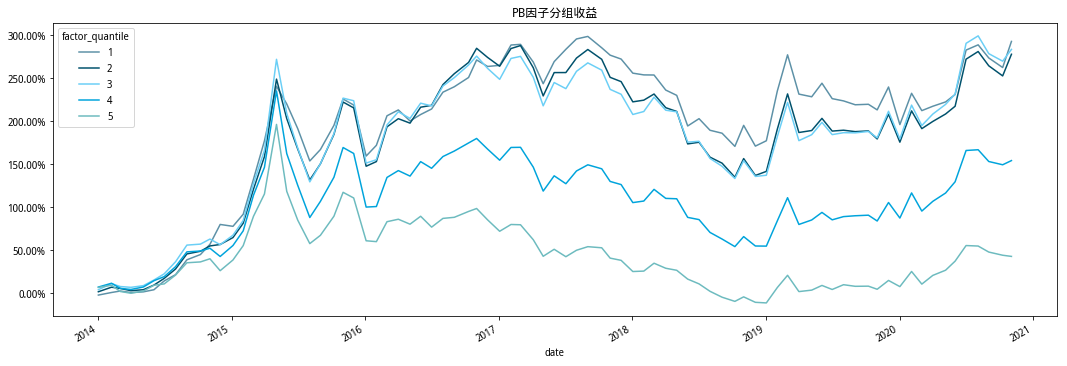

In [15]:
pb_ret = pd.pivot_table(pb_factor.reset_index(),index='date',columns='factor_quantile',values=1)

fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title('PB因子分组收益')
ax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, pos: '%.2f%%' % (x * 100)))

color_map = ['#5D91A7', '#00516C', '#6BCFF6', '#00A4DC', '#6DBBBF', '#008982']
ep.cum_returns(pb_ret).plot(ax=ax,color=color_map);

In [16]:
Strategy_performance(pb_ret,'monthly').style.format('{:.2%}')

factor_quantile,1,2,3,4,5
年化收益率,21.88%,21.20%,21.46%,14.44%,5.25%
累计收益,293.05%,278.09%,283.75%,154.16%,42.50%
波动率,27.42%,30.85%,32.85%,33.71%,34.43%
夏普,85.93%,77.52%,75.23%,56.55%,31.69%
最大回撤,-32.13%,-39.53%,-38.37%,-54.10%,-70.21%


# FScore财务模型

## 以与收益率相关性最高的财务指标筛选为核心

比乔斯基在其模型中选用了代表盈利水平、财务杠杆及流动性和运营效率的 9 个财务指标 对股票进行优劣筛选。首先将这三个领域共九个指标采用 0-1 度量（即参数为 1 或者 0），
使得股票的得分为 0 至 9 分。分数越高时，代表该股票的投资价值越高。

FScore分值分布,可以看到绝大多数股票得分为3至4分

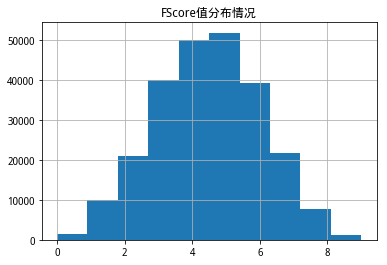

In [17]:
plt.title('FScore值分布情况')
FScore_factor['FScore'].hist();

原始财务指标的统计信息如下

In [18]:
basic_df.describe().T.style.format('{:.4f}')

,count,mean,std,min,25%,50%,75%,max
ROA,243391.0000,1.0684,1.9380,-124.7700,0.2300,0.8400,1.7400,114.0100
CFO,242799.0000,0.0056,0.0394,-1.0898,-0.0113,0.0065,0.0242,0.7908
DELTA_ROA,232114.0000,-0.1687,19.7152,-2149.8000,-0.5625,-0.1147,0.2418,2292.6364
ACCRUAL,242764.0000,-0.0051,0.0393,-1.2975,-0.0209,-0.0026,0.0130,1.2546
DELTA_LEVELER,216819.0000,-117.5187,21233.5567,-4896347.5711,-0.3860,0.0355,0.2732,2239.4868
DLTA_LIQUID,228151.0000,0.0552,1.5493,-67.6335,-0.1781,-0.0299,0.1178,264.4299
DELTA_MARGIN,228051.0000,0.2942,53.6886,-1542.3056,-0.1368,-0.0068,0.1228,10209.5201
DELTA_TURN,229540.0000,7864.0876,3767598.7658,-20129.0717,-0.1762,-0.0245,0.1340,1805069110.1253
EQ_OFFSER,232508.0000,0.2016,0.6812,-0.8999,0.0000,0.0000,0.1236,34.8357


测试实施细节:

1. 选股范围为全A,等权重，不考虑交易费用
2. 样本：2012-11-01至2021-01-31期间的所有A股上市公司。将每期FFScore按【0-4】、【5-9】进行分组，月度调仓。

In [19]:
# 将FFScore按0-1分和8至9分进行分组
factor_data = al.utils.get_clean_factor_and_forward_returns(FScore_factor,
                                                           pivot_price,
                                                           quantiles = None,
                                                           bins=[0,1,7,9],
                                                           periods=(1,))

Dropped 2.1% entries from factor data (1.5% after in forward returns computation and 0.6% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [20]:
benchmark = list(get_factor_price('000300.XSHG', price_periods))
benchmark = pd.concat(benchmark)
benchmark_ret = benchmark['close'].pct_change()

In [21]:
ret = pd.pivot_table(factor_data.reindex(),
                     index='date',
                     columns='factor_quantile',
                     values=1)

ret.rename(columns={1.0: 'FScore低分组',2.0:'中间组', 3.0: 'FScore高分组'}, inplace=True)

仅使用FScore财务模型进行选股,高分组累计收益332.06%,年化收益20.07%,夏普及回撤均优于低分组及中间组。

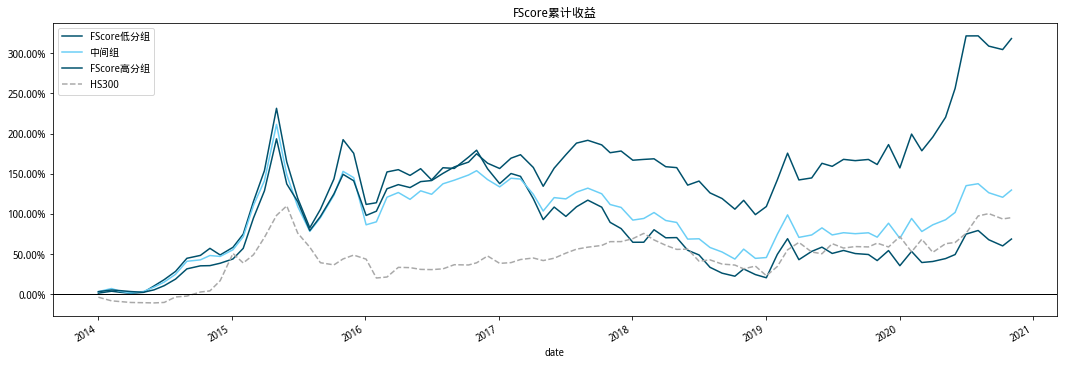

In [22]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title('FScore累计收益')
ax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, pos: '%.2f%%' % (x * 100)))

ep.cum_returns(ret).plot(ax=ax,color=['#00516C', '#6BCFF6'])
ep.cum_returns(benchmark_ret.reindex(ret.index)).plot(ax=ax,
                                   label='HS300',
                                   color='darkgray',
                                   ls='--')
ax.axhline(0, color='black', lw=1)
plt.legend();

In [23]:
Strategy_performance(ret,'monthly').style.format('{:.2%}')

factor_quantile,FScore低分组,中间组,FScore高分组
年化收益率,7.84%,12.77%,22.99%
累计收益,68.52%,129.56%,318.33%
波动率,35.13%,31.33%,29.22%
夏普,38.57%,53.87%,85.52%
最大回撤,-63.72%,-53.89%,-38.97%


## 比乔斯基9指标模型策略回测结果分析

用比乔斯基 FScore 模型中的 9 个选股标准对低 PB 股票进行筛选进行历史回测，同 时比较低市净率策略与 FScore 模型之间的差别。

FScore 策略与低市净率策略的年化收益率分别为14.65%和14.69%；A股市场中比乔斯基FScore策略并未跑赢作为基准的低市净率策略，更高的波动率对整体收益带来了更多不确定性，因此可知**原始比乔斯基模型在A股市场并不完全有效**

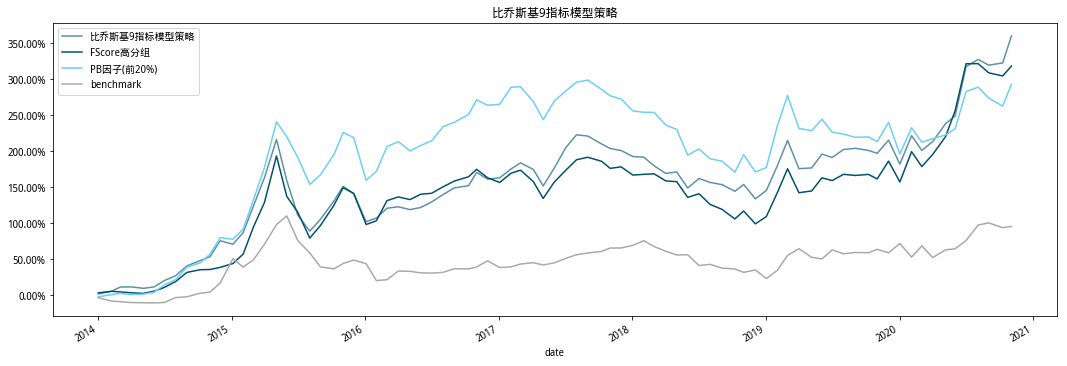

In [24]:
df = factor_data.copy()
df['pb_group'] = pb_factor['factor_quantile']

cross_df = df.query('pb_group == 1 and factor_quantile == 3')
cross_ret = pd.pivot_table(cross_df.reset_index(),index='date',columns='factor_quantile',values=1)

fih,ax = plt.subplots(figsize=(18,6))
ax.set_title('比乔斯基9指标模型策略')

all_ret = pd.concat((cross_ret[3],ret['FScore高分组'],pb_ret[1],benchmark_ret.reindex(cross_ret.index)),axis=1)
all_ret.columns = ['比乔斯基9指标模型策略','FScore高分组','PB因子(前20%)','benchmark']

ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos:'%.2f%%'%(x*100)))
ep.cum_returns(all_ret).plot(ax=ax,color=color_map[:3] + ['darkgray'])
ax.legend();

In [25]:
Strategy_performance(all_ret,'monthly').style.format('{:.2%}')

,比乔斯基9指标模型策略,FScore高分组,PB因子(前20%),benchmark
年化收益率,24.70%,22.99%,21.88%,10.15%
累计收益,360.37%,318.33%,293.05%,95.17%
波动率,27.15%,29.22%,27.42%,24.81%
夏普,95.40%,85.52%,85.93%,51.08%
最大回撤,-40.30%,-38.97%,-32.13%,-42.85%
IR,11.61%,10.36%,9.69%,nan%
Alpha,23.10%,21.97%,20.31%,nan%
超额收益,14.55%,12.84%,11.73%,0.00%


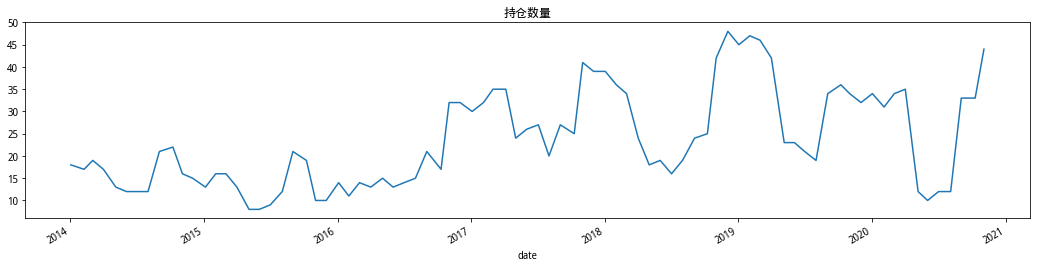

In [26]:
cross_df.groupby(level='date')['factor'].count().plot(title='持仓数量',figsize=(18,4));

# 中国版Fscore财务模型

A股市场相对于美国市场的波动更高、以及9个财务指标来进行筛选高分股票数量偏少导致的投资收益的风险增大的原因，同时可能还由于财务报告编制方法、中美财务指标的计算原则、以及 A股市场投资者对财务指标变化的理解有所不同，我们尝试进一步优化原有的比乔斯基低市净率9指标FScore选股策略，并提出了更适合中国A股市场的Five FScore（FFScore）低市净率选股模型。

**华泰低市净率 FFScore 模型财务指标的获取与计算方法**

**盈利水平**

1. 资产收益率(ROE)：收益率为正数时ROE=1，否则为0。
2. 资产收益率变化($\Delta ROE$)：当期最新可得财务报告的ROE同比的变化。 变化为正数时$\Delta ROE$=1，否则为0。

**财务杠杆和流动性**

3. 杠杆变化($\Delta LEVER$)：杠杆通过非流动负债合计除以非流动资产合计计 算，杠杆变化为当期最新可得财务报告的杠杆同比的变化。变化为负数时$\Delta LEVER$=1，否则为0。

**运营效率**

从财务分析的角度考虑，销售毛利率增量($\Delta MARGIN$)中毛利润除以营业收入的构成， 这与$\Delta ROE$指标的选取要素净利润类似，均含有利润相关的指标。一定程度上和盈利水平指标重复。在5指标模型中已经分析得到$\Delta MARGIN$与$\Delta ROE$指标的相关度达到了0.64892。因此即使在使用单个指标时效果优异，组合后的效果并不明显。类似的，我们选取净利率($\Delta NETMARGIN$)后发现，组合的效果并不理想。因此我们选择加入了流动 资产周转率变化($\Delta CATURN$)指标，通过主营业务收入与流动资产的比例来反映流动资产的周转速度，来衡量企业在生产运营上对流动资产的利用效率。

4. 流动资产周转率变化($\Delta CATURN$)： 流动资产周转率变化为当期最新可 得财务报告的资产周转率同比的变化。变化为正数时$\Delta CATURN$ =1，否则为0。
5. 资产周转率变化($\Delta TURN$)： 资产周转率通过总资产周转率除以平均资 产总值计算，资产周转率变化为当期最新可得财务报告的资产周转率同比的变化。变化为正数时$\Delta TURN$ =1，否则为0

因为只有五个财务指标故名字为Five_FScore(简称:FFScore)：

$Five\_FScore = ROE + \Delta ROE + \Delta CATURN + \Delta TURN + \Delta LEVER$

In [30]:
# 设置时间范围
startDt, endDt = '2014-01-01', '2020-12-31'
# 每月初
periods: List = get_trade_period(startDt, endDt, 'M')

# 获取FFScore得分
data_list1 = list(get_FFScore('A', FFScore, periods))

# 因子值
FFScore_factor: pd.Series = pd.concat(
    {pd.to_datetime(f.watch_date): f.ffscore
     for f in data_list1},
    names=['date', 'asset'])

# 基础数据
basic_df1: pd.DataFrame = pd.concat({f.watch_date: f.basic
                                    for f in data_list1},
                                   names=['date', 'asset'])

In [32]:
# 储存
FFScore_factor.to_frame('FFScore').to_csv('FFScore.csv')

In [33]:
# 读取
FFScore_factor = pd.read_csv('FFScore.csv', 
                             index_col=[0,1], 
                             parse_dates=[0])

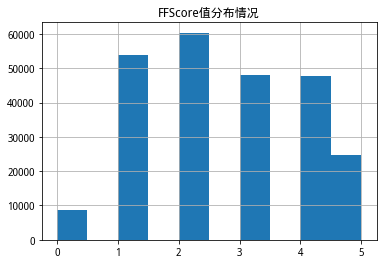

In [34]:
plt.title('FFScore值分布情况')
FFScore_factor['FFScore'].hist();

In [35]:
# 将FFScore按0-5分和5至8分进行分组
factor_data1 = al.utils.get_clean_factor_and_forward_returns(FFScore_factor,
                                                           pivot_price,
                                                           quantiles = None,
                                                           bins=[0,3,5],
                                                           periods=(1,))

Dropped 5.0% entries from factor data (1.5% after in forward returns computation and 3.6% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [36]:
ret1 = pd.pivot_table(factor_data1.reindex(),
                     index='date',
                     columns='factor_quantile',
                     values=1)

ret1.rename(columns={1.0: 'FFScore低分组', 2.0: 'FFScore高分组'}, inplace=True)

近FFScore财务模型选股,高分组比FScore略有下降

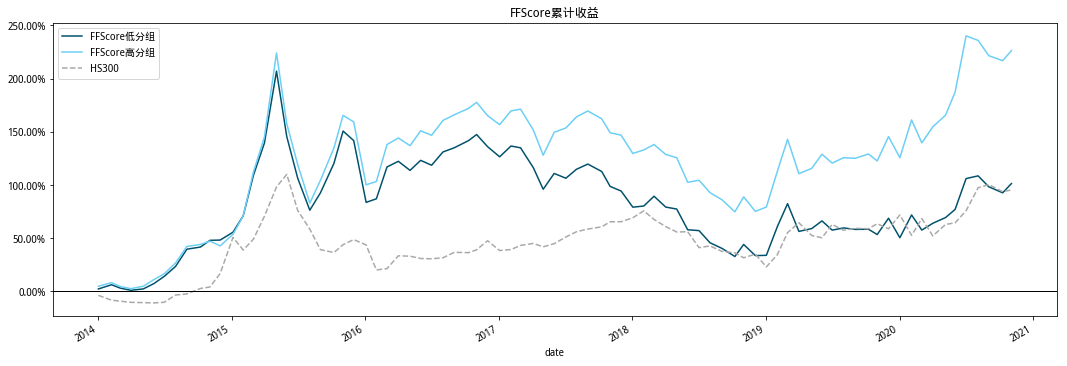

In [37]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title('FFScore累计收益')
ax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, pos: '%.2f%%' % (x * 100)))

ep.cum_returns(ret1).plot(ax=ax,color=['#00516C', '#6BCFF6'])
ep.cum_returns(benchmark_ret.reindex(ret1.index)).plot(ax=ax,
                                   label='HS300',
                                   color='darkgray',
                                   ls='--')
ax.axhline(0, color='black', lw=1)
plt.legend();

In [38]:
Strategy_performance(ret1,'monthly').style.format('{:.2%}')

factor_quantile,FFScore低分组,FFScore高分组
年化收益率,10.63%,18.65%
累计收益,101.17%,226.31%
波动率,31.30%,32.03%
夏普,47.77%,69.28%
最大回撤,-56.81%,-46.11%


但相较于FScore选股策略来说结合低市盈率后收益从14.69%提升至18.09%(原始财务模型策略为14.65%)

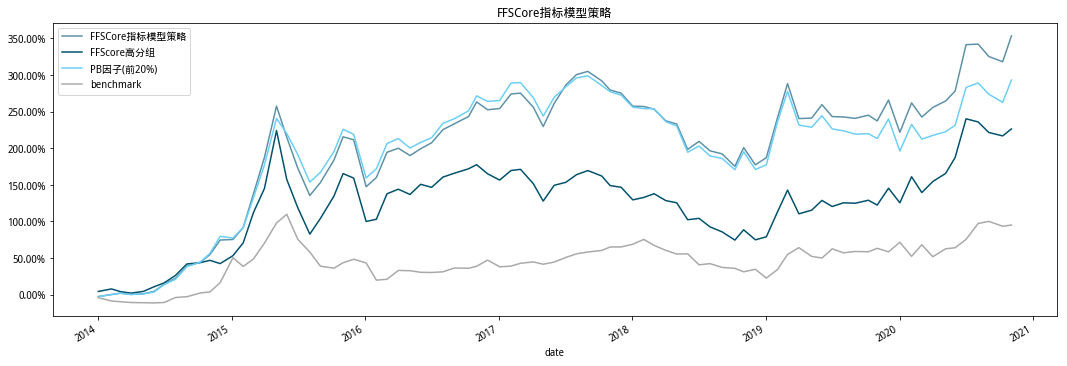

In [39]:
df = factor_data1.copy()
df['pb_group'] = pb_factor['factor_quantile']

cross_df1 = df.query('pb_group == 1 and factor_quantile == 2').copy()
cross_ret1 = pd.pivot_table(cross_df1.reset_index(),index='date',columns='factor_quantile',values=1)

fih,ax = plt.subplots(figsize=(18,6))
ax.set_title('FFSCore指标模型策略')

all_ret = pd.concat((cross_ret1[2],ret1['FFScore高分组'],pb_ret[1],benchmark_ret.reindex(cross_ret1.index)),axis=1)
all_ret.columns = ['FFSCore指标模型策略','FFScore高分组','PB因子(前20%)','benchmark']

ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos:'%.2f%%'%(x*100)))
ep.cum_returns(all_ret).plot(ax=ax,color=color_map[:3] + ['darkgray'])
ax.legend();

In [40]:
Strategy_performance(all_ret,'monthly').style.format('{:.2%}')

,FFSCore指标模型策略,FFScore高分组,PB因子(前20%),benchmark
年化收益率,24.42%,18.65%,21.88%,10.15%
累计收益,353.33%,226.31%,293.05%,95.17%
波动率,28.86%,32.03%,27.42%,24.81%
夏普,90.34%,69.28%,85.93%,51.08%
最大回撤,-34.13%,-46.11%,-32.13%,-42.85%
IR,11.58%,7.59%,9.69%,nan%
Alpha,22.64%,18.76%,20.31%,nan%
超额收益,14.27%,8.50%,11.73%,0.00%


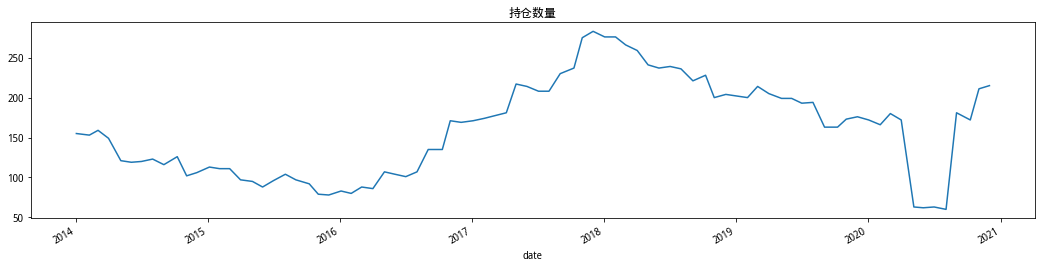

In [309]:
cross_df1.groupby(level='date')['factor'].count().plot(title='持仓数量',figsize=(18,4));

## 策略组合的行业分布

In [209]:
cross_df1['industry'] = cross_df1.groupby(
    level='date').apply(lambda x: get_stock_ind(
        x.index.get_level_values(1).values.tolist(), x.name, 'sw_l1',
        'industry_name'))

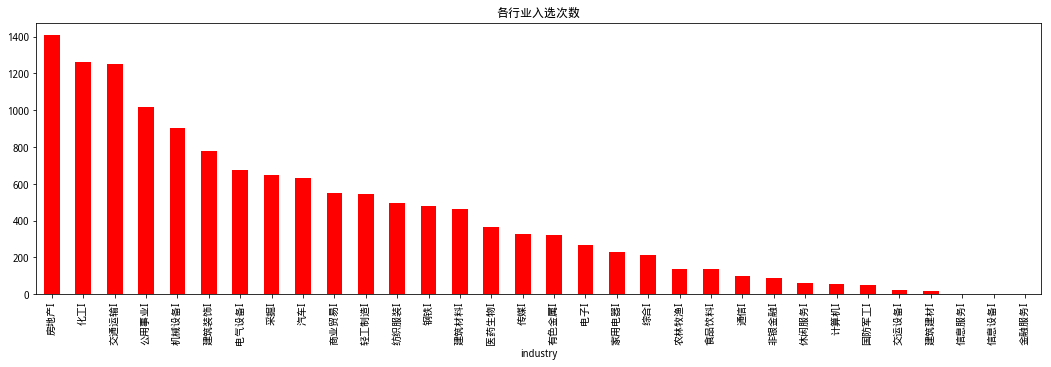

In [210]:
cross_df1.groupby('industry')[1].count().sort_values(ascending=False).plot.bar(
    color='r', figsize=(18, 5), title='各行业入选次数');

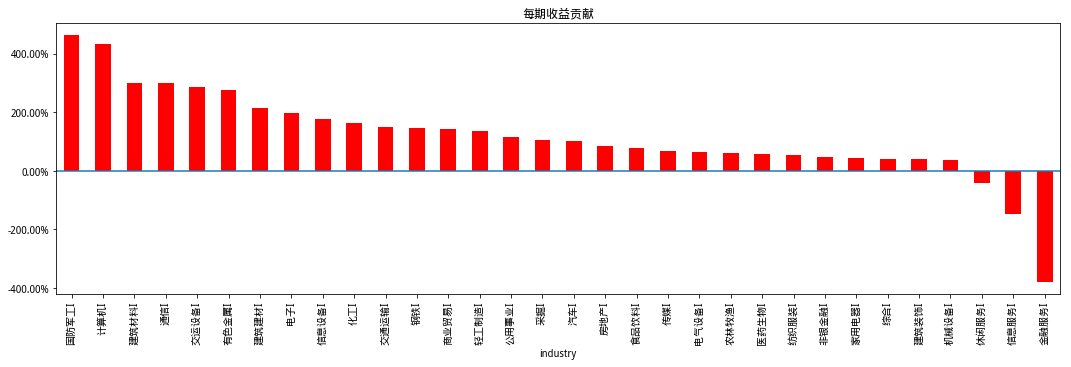

In [215]:
fig,ax = plt.subplots(figsize=(18,5))

ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x,pos:'{:.2%}'.format(x * 100)))
cross_df1.groupby('industry')[1].mean().sort_values(ascending=False).plot.bar(
    color='r', figsize=(18, 5),title='每期收益贡献',ax=ax)

plt.axhline(0);

# 使用随机森林算法分析特征

In [227]:
# 涉及到的13个财务指标获取
class F13_Score(Factor):
    
    '''获取FScore及FFScore中提到的因子'''
    name = 'F15_Score'
    max_window = 1
    watch_date = None
    
    dependencies = ['roa', 'roa_4', 'net_operate_cash_flow', 'total_assets',
        'total_assets_1', 'total_assets_4', 'total_assets_5',
        'operating_revenue', 'operating_revenue_4','pb_ratio',
        'total_current_assets','total_current_assets_1','total_current_assets_4','total_current_assets_5',
        'total_non_current_assets', 'total_non_current_liability',
        'total_non_current_assets_4', 'total_non_current_liability_4',
        'total_current_assets', 'total_current_liability',
        'total_current_assets_4', 'total_current_liability_4',
        'gross_profit_margin', 'gross_profit_margin_4', 'paidin_capital',
        'paidin_capital_4','roe', 'roe_4','total_profit','total_profit_4','financial_expense','financial_expense_4']
    
    def calc(self,data:dict)->None:
        
        roe: pd.DataFrame = data['roe']
        
        roa1: pd.DataFrame = data['roa'] # 单位为百分号
        
        # 息税前利润（EBIT）除以资产总值
        # 利息支出项大多数情况时缺失的所以这里用财务费用代替
        roa2 = data['total_profit'] + data['financial_expense'] / (
            data['total_current_assets'] +
            data['total_current_assets_1']).mean()
        
        roa2_4 = data['total_profit_4'] + data['financial_expense_4'] / (
            data['total_current_assets_4'] +
            data['total_current_assets_5']).mean()
        
        delta_roa2 = roa2 / roa2_4 - 1
        
        cfo: pd.DataFrame = data['net_operate_cash_flow'] / \
            data['total_assets']

        delta_roa1: pd.DataFrame = roa1 / data['roa_4'] - 1
        
        delta_roe: pd.DataFrame = roe / data['roe_4'] - 1
            
        accrual: pd.DataFrame = cfo - roa1 * 0.01

        # 杠杆变化
        ## 变化为负数时为1，否则为0 取相反
        leveler: pd.DataFrame = data['total_non_current_liability'] / \
            data['total_non_current_assets']

        leveler1: pd.DataFrame = data['total_non_current_liability_4'] / \
            data['total_non_current_assets_4']

        delta_leveler: pd.DataFrame = -(leveler / leveler1 - 1)

        # 流动性变化
        liquid: pd.DataFrame = data['total_current_assets'] / \
            data['total_current_liability']

        liquid_1: pd.DataFrame = data['total_current_assets_4'] / \
            data['total_current_liability_4']

        delta_liquid: pd.DataFrame = liquid / liquid_1 - 1

        # 毛利率变化
        delta_margin: pd.DataFrame = data['gross_profit_margin'] / \
            data['gross_profit_margin_4'] - 1

        # 是否发行普通股权
        eq_offser: pd.DataFrame = data['paidin_capital'] / data[
            'paidin_capital_4'] - 1
        
        # 流动资产周转率
        caturn_1 = data['operating_revenue'] / (
            data['total_current_assets'] +
            data['total_current_assets_1']).mean()
        caturn_2 = data['operating_revenue_4'] / (
            data['total_current_assets_4'] +
            data['total_current_assets_5']).mean()
        
        # 流动资产周转率同比
        delata_caturn = caturn_1 / caturn_2 - 1
        
        # 总资产周转率
        total_asset_turnover_rate: pd.DataFrame = data[
            'operating_revenue'] / (data['total_assets'] +
                                          data['total_assets_1']).mean()

        total_asset_turnover_rate_1: pd.DataFrame = data[
            'operating_revenue_4'] / (data['total_assets_4'] +
                                            data['total_assets_5']).mean()

        # 总资产周转率同比
        delta_turn: pd.DataFrame = total_asset_turnover_rate / \
            total_asset_turnover_rate_1 - 1
        
        indicator_tuple: Tuple = (roe, delta_roe,roa1,delta_roa1,roa2,delta_roa2, accrual, delta_leveler,
                                  delta_liquid, delta_margin,eq_offser,delata_caturn, delta_turn,data['pb_ratio'])

        # 储存计算FFscore所需原始数据
        self.basic: pd.DataFrame = pd.concat(indicator_tuple).T.replace([-np.inf,np.inf],np.nan)

        self.basic.columns = [
            'ROE', 'DELTA_ROE','ROA1','DELTA_ROA1','ROA2','DELTA_ROA2','ACCRUAL', 'DELTA_LEVER', 
            'DLTA_LIQUID', 'DELTA_MARGIN', 'EQ_OFFSER', 'DELTA_CATURN', 'DELTA_TURN','PB_RATIO']


In [228]:
# 设置时间范围
startDt, endDt = '2010-01-01', '2020-12-31'

# 每月初
periods: List = get_trade_period(startDt, endDt, 'M')
    
all_fundamentals_list = list(get_FFScore('A', F13_Score, periods))

In [229]:
all_fundamentals: pd.DataFrame = pd.concat({f.watch_date: f.basic
                                    for f in all_fundamentals_list},
                                   names=['date', 'asset'])

In [230]:
# all_fundamentals.to_csv('all_fundamentals.csv')

In [4]:
all_fundamentals = pd.read_csv('all_fundamentals.csv',index_col=[0,1],parse_dates=[0])

仅杠杆比率的缺失率高于10%

In [42]:
all_fundamentals.isna().sum() / len(all_fundamentals)

ROE             0.000255
DELTA_ROE       0.055107
ROA1            0.000255
DELTA_ROA1      0.056428
ROA2            0.021327
DELTA_ROA2      0.087180
ACCRUAL         0.002111
DELTA_LEVER     0.135790
DLTA_LIQUID     0.071811
DELTA_MARGIN    0.070257
EQ_OFFSER       0.054317
DELTA_CATURN    0.087437
DELTA_TURN      0.070023
PB_RATIO        0.000000
dtype: float64

In [7]:
price_periods = get_trade_period('2010-01-01', '2021-01-31', 'M')

# 股票池
securities = all_fundamentals.index.levels[1].tolist()

# 获取收盘价
price_list = list(get_factor_price(securities, price_periods))

price_df = pd.concat(price_list)

pivot_price = pd.pivot_table(price_df,
                             index='time',
                             columns='code',
                             values='close')

next_ret = pivot_price.pct_change().shift(-1)
next_ret = next_ret.iloc[:-1].stack()

仅使用2010至2013年的数据进行特征分析

In [8]:
# 训练集 使用2010-01-01至2013-12-02的数据进行训练
X_train_time = price_periods[:48]  # 2013-12-02

X_train = all_fundamentals.loc[X_train_time]
X_train = X_train.iloc[:, :-1]
y_train = next_ret.loc[X_train_time]
y_train = y_train.reindex(X_train.index)

# 测试集
X_test = all_fundamentals.loc[price_periods[48:]]
X_test_fundamentals = X_test.iloc[:,:-1]
X_test_pb = X_test.iloc[:,-1]
y_test = next_ret.reindex(X_test.index)

In [9]:
rnd_clf = RandomForestClassifier(n_estimators=200,
                                 max_leaf_nodes=8,
                                 max_depth=10,
                                 n_jobs=-1,
                                 random_state=42,
                                 criterion='entropy')

rnd_clf.fit(X_train.fillna(0).values, sign(y_train).values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=8,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

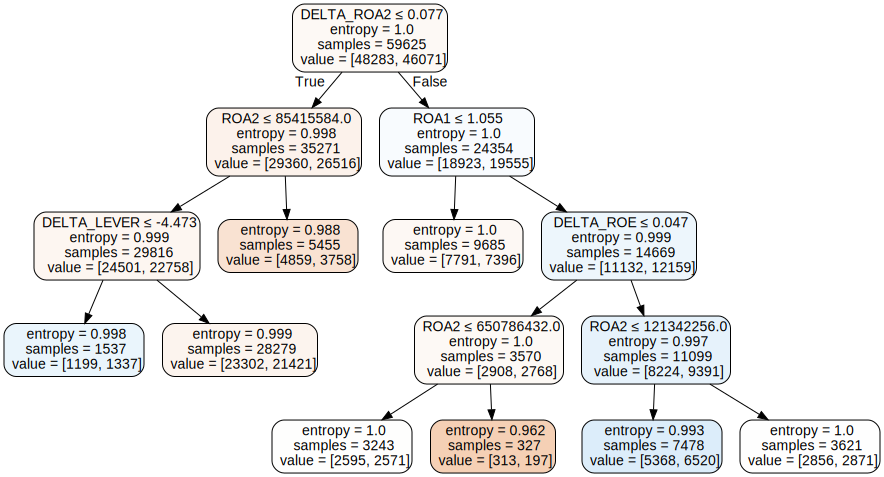

In [10]:
dot_data = export_graphviz(rnd_clf.estimators_[-1],
                           out_file=None,
                           feature_names=X_train.columns.tolist(),
                           filled=True,
                           rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)

graph

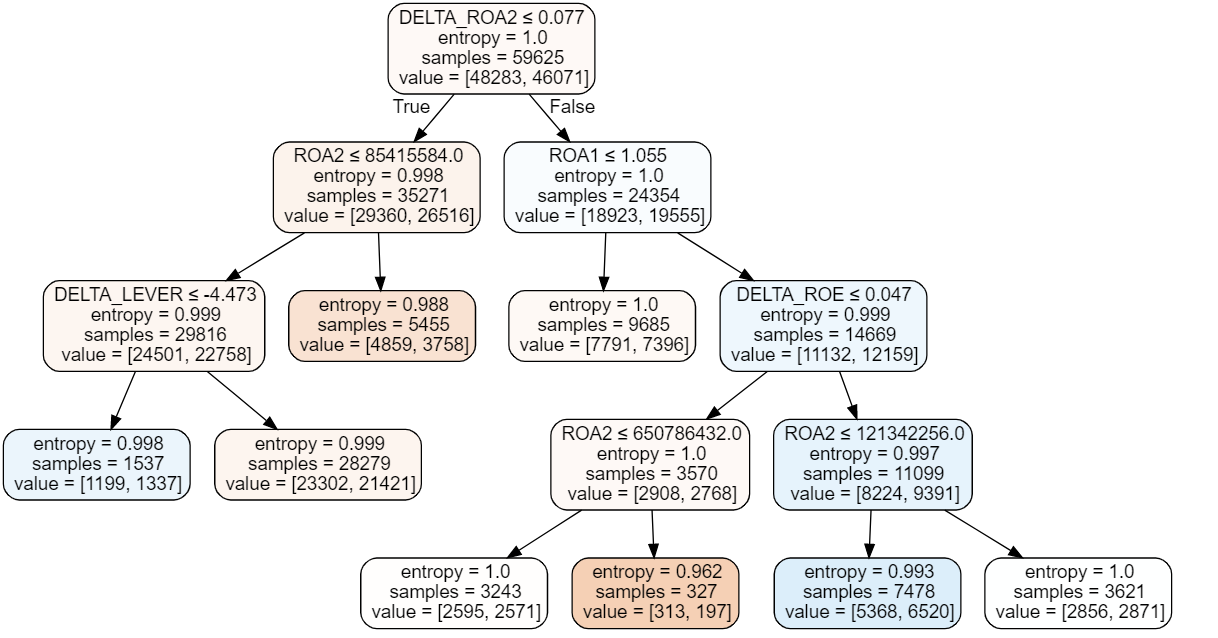

下图可以看到关键特征从$\Delta ROE$至$\Delta ROA1$时重要性已经大于80%,$\Delta ROA1$与$\Delta ROE$相关系数为0.49这里我们试着将DELTA_ROA1剔除,构建以$\Delta ROE,ROA2,\Delta MARGIN,\Delta CATURN,Delta ROA2,\Delta LIQUID$为基础的6因子财务打分模型。

**盈利水平**

1. $\Delta ROE$
2. ROA2(息税前利润（EBIT）除以资产总值)
3. $\Delta ROA2$

**财务杠杆及流动性**

4. $\Delta LIQUID$
5. $\Delta CATURN$

**运营效率**

6. $\Delta MAGRIN$

$SFScore = \Delta ROE + ROA2 + \Delta ROA2 + \Delta LIQUID + \Delta CATURN + \Delta MAGRIN$

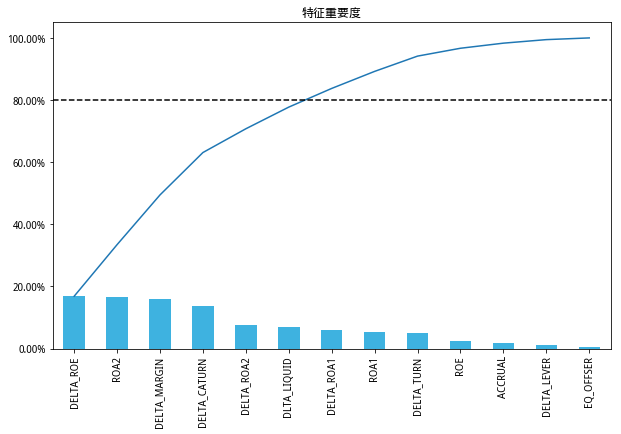

In [48]:
# 特征重要性
feature_score = pd.Series(index=X_train.columns.tolist(),
                          data=rnd_clf.feature_importances_).sort_values(ascending=False)


fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title('特征重要度')
ax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, pos: '{:.2%}'.format(x)))

feature_score.plot.bar(ax=ax,color='#3EB2E0')
feature_score.cumsum().plot.line(ax=ax,rot=90)
plt.axhline(0.8,color='black',ls='--');

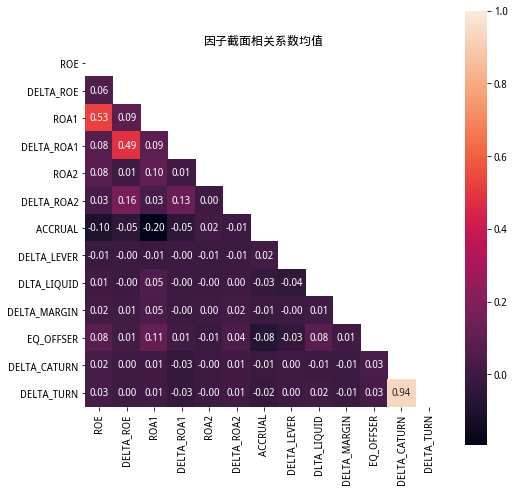

In [49]:
# 因子每期截面均值
corr = X_train.groupby(level='date').corr()
for i, (trade, df) in enumerate(corr.groupby(level='date'), start=1):

    if i == 1:
        corr_mean = df.xs(trade)
    else:
        corr_mean += df.xs(trade)

corr_mean /= i

mask = np.zeros_like(corr_mean)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(8, 8))
ax.set_title('因子截面相关系数均值')
ax = sns.heatmap(corr_mean, mask=mask, square=True, annot=True, fmt='.2f')

In [50]:
sfscore = sign(X_test_fundamentals[[
    'DELTA_ROE', 'ROA2', 'DELTA_MARGIN', 'DELTA_CATURN', 'DELTA_ROA2',
    'DLTA_LIQUID'
]]).sum(axis=1)

sfscore.name = 'SFScore'

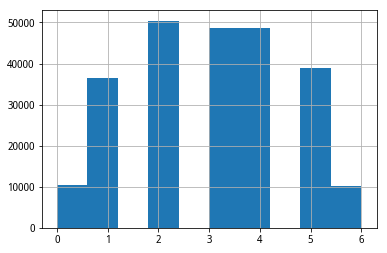

In [51]:
sfscore.hist()

In [58]:
# 将FFScore按0-5分和5至8分进行分组
factor_data2 = al.utils.get_clean_factor_and_forward_returns(sfscore,
                                                           pivot_price,
                                                           quantiles = None,
                                                           bins=[0,4,6],
                                                           periods=(1,))

Dropped 4.2% entries from factor data (0.0% after in forward returns computation and 4.2% in binning phase). Set max_loss=0 to see potentially suppressed Exceptions.


In [59]:
ret2 = pd.pivot_table(factor_data2.reindex(),
                     index='date',
                     columns='factor_quantile',
                     values=1)

ret2.rename(columns={1.0: 'SFScore低分组', 2.0: 'SFScore高分组'}, inplace=True)

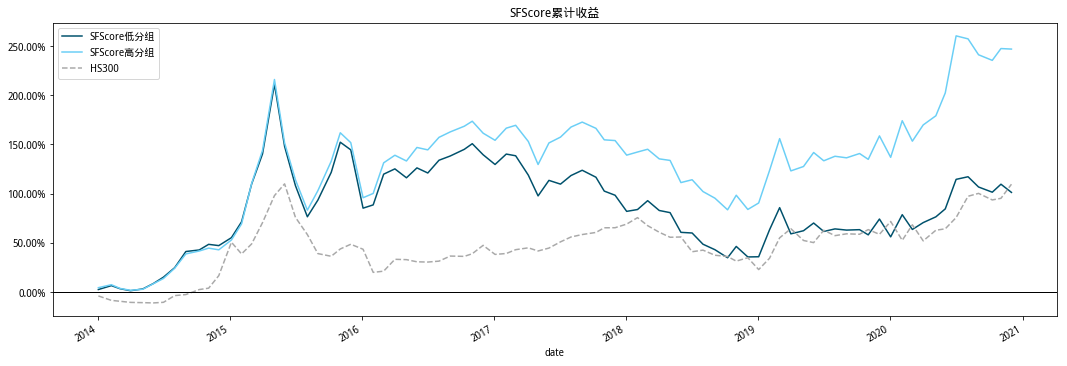

In [60]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_title('SFScore累计收益')
ax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, pos: '%.2f%%' % (x * 100)))

ep.cum_returns(ret2).plot(ax=ax,color=['#00516C', '#6BCFF6'])
ep.cum_returns(benchmark_ret.reindex(ret2.index)).plot(ax=ax,
                                   label='HS300',
                                   color='darkgray',
                                   ls='--')
ax.axhline(0, color='black', lw=1)
plt.legend();

In [61]:
Strategy_performance(ret2,'monthly').style.format('{:.2%}')

factor_quantile,SFScore低分组,SFScore高分组
年化收益率,10.50%,19.44%
累计收益,101.18%,246.82%
波动率,31.58%,30.71%
夏普,47.21%,73.18%
最大回撤,-56.66%,-42.03%


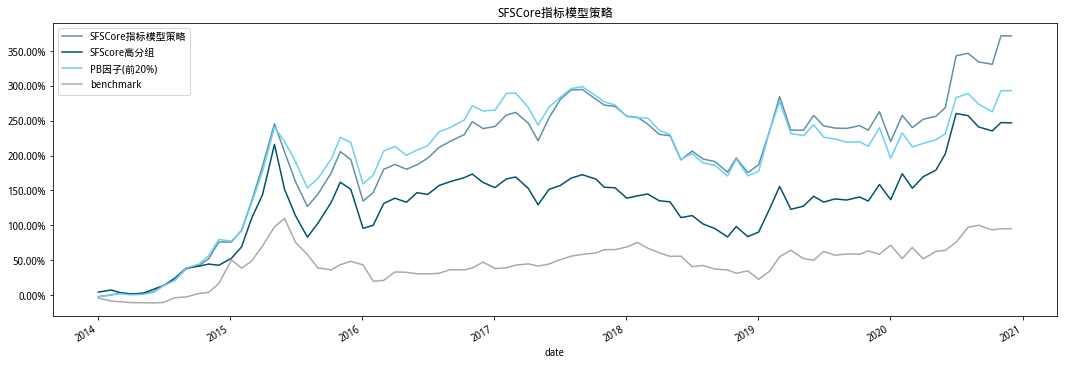

In [93]:
df = factor_data2.copy()
df['pb_group'] = pb_factor['factor_quantile']

cross_df2 = df.query('pb_group == 1 and factor_quantile == 2').copy()
cross_ret2 = pd.pivot_table(cross_df2.reset_index(),
                            index='date',
                            columns='factor_quantile',
                            values=1)

fih, ax = plt.subplots(figsize=(18, 6))
ax.set_title('SFSCore指标模型策略')

all_ret = pd.concat((cross_ret2[2], ret2['SFScore高分组'], pb_ret[1],
                     benchmark_ret.reindex(cross_ret2.index)),
                    axis=1)
all_ret.columns = ['SFSCore指标模型策略', 'SFScore高分组', 'PB因子(前20%)', 'benchmark']

ax.yaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, pos: '%.2f%%' % (x * 100)))
ep.cum_returns(all_ret).plot(ax=ax, color=color_map[:3] + ['darkgray'])
ax.legend()

In [95]:
Strategy_performance(all_ret,'monthly').style.format('{:.2%}')

,SFSCore指标模型策略,SFScore高分组,PB因子(前20%),benchmark
年化收益率,24.80%,19.44%,21.60%,10.02%
累计收益,371.53%,246.82%,293.05%,95.17%
波动率,28.43%,30.71%,27.42%,24.81%
夏普,93.35%,73.18%,85.93%,51.08%
最大回撤,-34.30%,-42.03%,-32.13%,-42.85%
IR,12.12%,8.24%,9.69%,nan%
Alpha,23.10%,19.48%,20.31%,nan%
超额收益,14.78%,9.42%,11.57%,0.00%


## 横向比较

可以看到从原始模型至改进模型,单独使用模型进行选股的选股能力是依次减弱的，由原始的22.68%减弱至19.44%。但对低PB组合的增强能力是依次增加的由24.7%增加至25.13%(相较于单独的PB因子选股收益的21.6%来说)

In [103]:
score_ret_df = pd.concat((ret['FScore高分组'],ret1['FFScore高分组'],ret2['SFScore高分组']),axis=1)

Strategy_performance(score_ret_df,'monthly').style.format('{:.2%}')

,FScore高分组,FFScore高分组,SFScore高分组
年化收益率,22.68%,18.41%,19.44%
累计收益,318.33%,226.31%,246.82%
波动率,29.22%,32.03%,30.71%
夏普,85.52%,69.28%,73.18%
最大回撤,-38.97%,-46.11%,-42.03%


In [101]:
cross_ret_df = pd.concat((cross_ret[3], cross_ret1[2], cross_ret2[2]), axis=1)
cross_ret_df.columns = ['FScore指标模型策略', 'FFScore指标模型策略', 'SFSCore指标模型策略']

Strategy_performance(cross_ret_df, 'monthly').style.format('{:.2%}')

,FScore指标模型策略,FFScore指标模型策略,SFSCore指标模型策略
年化收益率,24.70%,24.42%,25.13%
累计收益,360.37%,353.33%,371.53%
波动率,27.15%,28.86%,28.43%
夏普,95.40%,90.34%,93.35%
最大回撤,-40.30%,-34.13%,-34.30%
